# Assignment 4: Text and Sequence Data

# Shefali Gupta

Loading the required libraries

In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from google.colab import files
import re, os
from keras.datasets import imdb
from keras import preprocessing
from keras.utils import pad_sequences


Processing words in the form of a sequence: The approach using sequence models.

In [3]:
from google.colab import drive
import os

# Check if Google Drive is mounted, and remount if needed
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive', force_remount=True)

# Navigating to a directory in your Google Drive
%cd /content/drive/MyDrive/

# Defining the dataset URL
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Defining the destination path for the downloaded dataset
download_path = "/content/drive/MyDrive/aclImdb_v1.tar.gz"

# Downloading the dataset
!wget $dataset_url -O $download_path

# Extracting the dataset
!tar -xf $download_path

# Removing unnecessary directory
!rm -r /content/drive/MyDrive/aclImdb/train/unsup


/content/drive/MyDrive
--2023-11-28 04:52:12--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/aclImdb_v1.tar.gz’

/content/drive/MyDr 100%[===================>]  80.23M  3.24MB/s    in 18s     

2023-11-28 04:52:30 (4.46 MB/s) - ‘/content/drive/MyDrive/aclImdb_v1.tar.gz’ saved [84125825/84125825]

^C


In [4]:
# Importing necessary libraries and modules
import os, pathlib, shutil, random
from tensorflow import keras

# Defining batch size for data loading
batch_size = 32

# Setting up directory paths for training, validation, and testing data within the IMDB dataset
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

# Organizing data for sentiment analysis: Creating validation sets
for category in ("neg", "pos"):
    # Creating subdirectories for validation data
    os.makedirs(val_dir / category, exist_ok=True)

    # Listing files in the training directory for the current sentiment category
    files = os.listdir(train_dir / category)

    # Shuffling the list of files with a fixed seed for reproducibility
    random.Random(1234).shuffle(files)

    # Calculating the number of validation samples (20% of the total files)
    num_val_samples = int(0.2 * len(files))

    # Selecting the last portion of the shuffled files as validation files
    val_files = files[-num_val_samples:]

    # Moving validation files from the training directory to the validation directory
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

# Creating text datasets for training, validation, and testing using TensorFlow's text_dataset_from_directory
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

# Creating a text-only training dataset by mapping the input data to include only the text (input feature) without labels (output/target)
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 4259 files belonging to 2 classes.
Found 19762 files belonging to 2 classes.
Found 26741 files belonging to 2 classes.


In [5]:
# Setting maximum length for sequences and maximum number of tokens
max_length = 600
max_tokens = 20000

# Creating a TextVectorization layer with specified parameters
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

# Adapting the TextVectorization layer to the text-only training dataset
text_vectorization.adapt(text_only_train_ds)

# Mapping the input data in the training dataset to integer sequences
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# Mapping the input data in the validation dataset to integer sequences
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

# Mapping the input data in the test dataset to integer sequences
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

In [6]:
from keras.layers import Embedding

# Creating an Embedding layer with 1000 input dimensions, embedding dimensionality of 64
embedding_layer = Embedding(1000, 64)


# Model 1

## Action 1. Cut off reviews after 150 words

In [7]:
# Number of words to consider as features
max_features = 10000

# Cutting texts after 150 words
maxlen = 150

# Loading the IMDB movie review dataset as lists of integers, limiting the vocabulary to the top 'max_features' words
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to ensure consistent length for input to a neural network
# This is necessary because neural networks expect inputs of the same length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 [==============================] - 0s 0us/step


### Initiating the training of a basic sequence model.

In [8]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# Creating a Sequential model
model = Sequential()

# Adding an Embedding layer with a vocabulary of 10,000, embedding dimension of 8, and input length of maxlen
model.add(Embedding(input_dim=10000, output_dim=8, input_length=maxlen))

# Flattening the embedded inputs to a 2D tensor
model.add(Flatten())

# Adding a binary classifier on top
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model with RMSprop optimizer and binary cross-entropy loss
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Displaying the model summary
model.summary()

# Training the model and storing the training history
Model_1 = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.5978 - acc: 0.6969 - val_loss: 0.4315 - val_acc: 0.8190
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3320 - acc: 0.8650 - val_loss: 0.3203 - val_acc: 0.8648
Epoch 3/10
625/625 [==============================] 

#### Extracting and Visualizing Training History

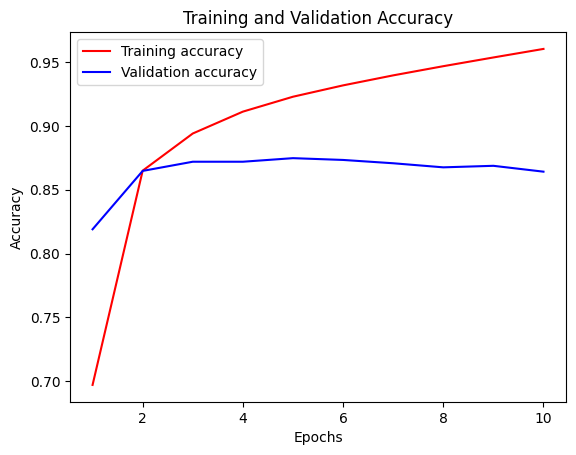

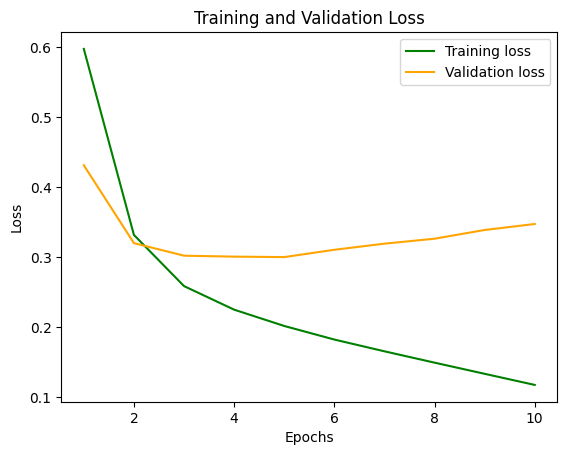

In [9]:
import matplotlib.pyplot as plt

# Extracting accuracy, validation accuracy, loss, and validation loss from the training history
accuracy = Model_1.history['acc']
val_accuracy = Model_1.history['val_acc']
loss = Model_1.history['loss']
val_loss = Model_1.history['val_loss']

# Generating a range of epochs for x-axis
epochs = range(1, len(accuracy) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Displaying a new figure for the loss plots
plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Displaying the plots
plt.show()


In [10]:
# Evaluating the trained model on the test dataset
test_loss, test_acc = model.evaluate(x_test, y_test)

# Printing the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


782/782 [==============================] - 1s 1ms/step - loss: 0.3483 - acc: 0.8659
Test loss: 0.34829801321029663
Test accuracy: 0.8659200072288513


# Model 2: Embedding layers with training samples = 100


In [11]:
max_features = 10000
maxlen = 150

# Loading the IMDB movie review dataset with a specified vocabulary size
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Padding sequences to ensure consistent length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Concatenating text sequences (x_train and x_test) and labels (y_train and y_test)
texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

# Selecting a subset of the training data (first 100 samples)
x_train = x_train[:100]
y_train = y_train[:100]


In [31]:
# Creating a Sequential model
model = Sequential()

# Adding an Embedding layer with input_dim=10000 (vocabulary size), output_dim=8 (embedding dimension), and input_length=maxlen
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the 3D tensor of embeddings into a 2D tensor
model.add(Flatten())

# Adding a Dense layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with rmsprop optimizer and binary crossentropy loss
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Displaying the model summary
model.summary()

# Training the model on the subset of the training data
Model_2 = model.fit(x_train, y_train,
                       epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_3 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 76ms/step - loss: 0.6895 - acc: 0.5375 - val_loss: 0.6934 - val_acc: 0.5500
Epoch 2/10
3/3 [==============================] - 0s 15ms/step - loss: 0.6659 - acc: 0.8750 - val_loss: 0.6917 - val_acc: 0.6000
Epoch 3/10
3/3 [==============================] - 0s 14m

Extracting and Visualizing Training History

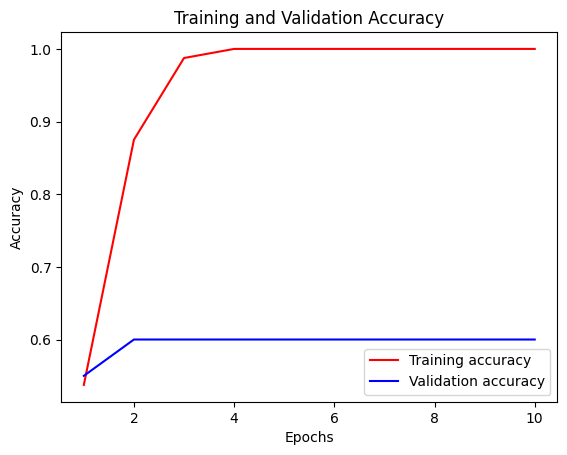

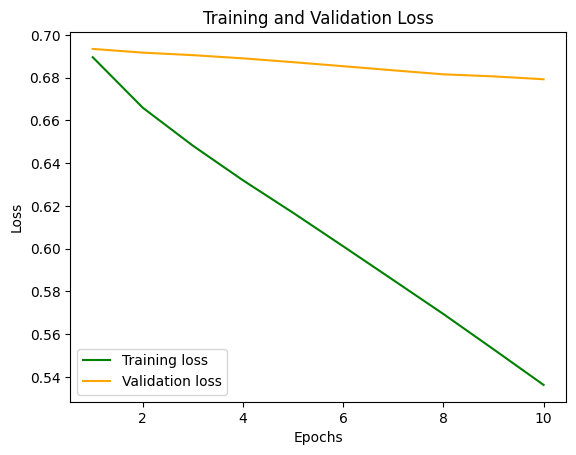

In [32]:
import matplotlib.pyplot as plt

# Extracting accuracy, validation accuracy, loss, and validation loss from the training history
accuracy = Model_2.history['acc']
val_accuracy = Model_2.history['val_acc']
loss = Model_2.history['loss']
val_loss = Model_2.history['val_loss']

# Generating a range of epochs for x-axis
epochs = range(1, len(accuracy) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Displaying a new figure for the loss plots
plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Displaying the plots
plt.show()


In [14]:
# Evaluating the trained model on the test dataset
test_loss, test_acc = model.evaluate(x_test, y_test)

# Printing the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


782/782 [==============================] - 1s 1ms/step - loss: 0.6938 - acc: 0.5019
Test loss: 0.69383305311203
Test accuracy: 0.5019199848175049


# Action 5. Using Bi-directional layers

#### will be using Action 3 & 4 below

Download the IMDB data as raw text -

In [15]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [16]:
import os

# Change the current working directory
os.chdir("/content/drive/MyDrive")

In [17]:
# Downloading the IMDB sentiment analysis dataset and extracting the contents
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

# Removing the 'unsup' directory from the training data
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  11.5M      0  0:00:06  0:00:06 --:--:-- 16.2M
^C


In [18]:
# Setting the directory path for the IMDB dataset or related files
imdb_dir = '/content/drive/MyDrive'

In [19]:
# Creating the complete path for the training directory within the IMDB dataset
train_dir = os.path.join(imdb_dir, 'train')

In [20]:
# Initializing empty lists for labels and texts
labels = []
texts = []

In [21]:
# Looping through negative and positive label types in the training directory
for label_type in ['/content/drive/MyDrive/aclImdb/train/neg', '/content/drive/MyDrive/aclImdb/train/pos']:
    # Creating the complete directory path
    dir_name = os.path.join(train_dir, label_type)

    # Iterating through files in the directory
    for fname in os.listdir(dir_name):
        # Checking if the file is a text file
        if fname[-4:] == '.txt':
            # Opening and reading the contents of the text file
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()

            # Assigning labels based on the directory type
            if label_type == '/content/drive/MyDrive/aclImdb/train/neg':
                labels.append(0)
            else:
                labels.append(1)


#  Model 3: Tokenizing the data
# Action 3: On 1000 samples
# Action 4: Considering only top 10000 samples



In [22]:
# Defining parameters for tokenization and padding
maxlen = 150
training_samples = 100
validation_samples = 10000
max_words = 10000

# Tokenizing the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Extracting the word index and printing the number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padding sequences to ensure consistent length
data = pad_sequences(sequences, maxlen=maxlen)

# Converting labels to a numpy array
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Shuffling the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Splitting the data into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 39408 unique tokens.
Shape of data tensor: (4259, 150)
Shape of label tensor: (4259,)


# Model 3 - Used Glove word embeddings

Pre-Processing the embeddings

In [23]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [24]:
# Setting the directory path for the GloVe embeddings
glove_dir = '/content/drive/MyDrive/glove.6B/glove'

# Importing necessary libraries
import re, os
import numpy as np

# Initializing a dictionary to store word embeddings
embeddings_index = {}

# Opening and reading the GloVe embedding file
f = open(os.path.join(glove_dir, '/content/drive/MyDrive/glove.6B/glove/glove.6B.100d.txt'))

# Parsing each line in the file to extract word and corresponding coefficients
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

# Closing the file after extracting word vectors
f.close()

# Displaying the number of word vectors found
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [25]:
embedding_dim = 100 # Defining the dimensionality of word embeddings

embedding_matrix = np.zeros((max_words, embedding_dim)) # Initializing the embedding matrix with zeros
word_index = tokenizer.word_index
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None: # Checking if an embedding vector is available for the word
           ## Setting the embedding vector in the matrix
           #consider the no text as Zero
            embedding_matrix[i] = embedding_vector

### Building the model

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 dense_2 (Dense)             (None, 150, 32)           3232      
                                                                 
 dense_3 (Dense)             (None, 150, 1)            33        
                                                                 
Total params: 1,003,265
Trainable params: 1,003,265
Non-trainable params: 0
_________________________________________________________________


### Incorporating GloVe embeddings into the model.

In [27]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [28]:
print("Training data shape:", y_train.shape)

Training data shape: (100,)


In [33]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model_3 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
4/4 [==============================] - 1s 91ms/step - loss: 0.5482 - acc: 0.9200 - val_loss: 0.6888 - val_acc: 0.5583
Epoch 2/10
4/4 [==============================] - 0s 52ms/step - loss: 0.5133 - acc: 0.9800 - val_loss: 0.6901 - val_acc: 0.5501
Epoch 3/10
4/4 [==============================] - 0s 51ms/step - loss: 0.4885 - acc: 0.9900 - val_loss: 0.6922 - val_acc: 0.5472
Epoch 4/10
4/4 [==============================] - 0s 52ms/step - loss: 0.4670 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 0.5470
Epoch 5/10
4/4 [==============================] - 0s 52ms/step - loss: 0.4473 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.5446
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 0.4287 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.5468
Epoch 7/10
4/4 [==============================] - 0s 51ms/step - loss: 0.4105 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.5472
Epoch 8/10
4/4 [==============================] - 0s 50ms/step - loss: 0.3921 - acc: 1.0000 - val

In [34]:
model.save_weights('/content/drive/MyDrive/pre_trained_glove_model.h5')

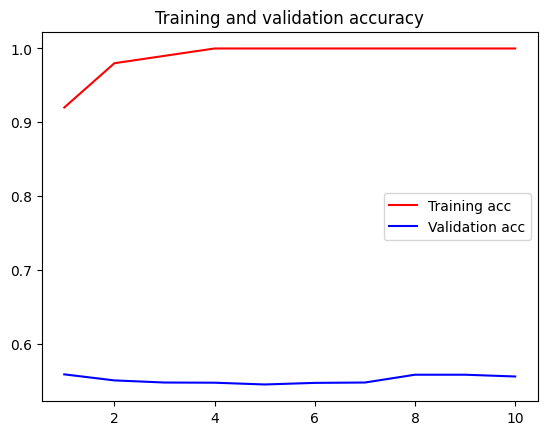

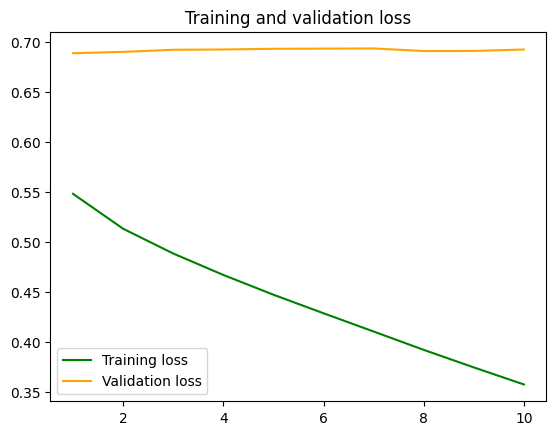

In [36]:
import matplotlib.pyplot as plt

acc = model_3.history['acc']
val_acc = model_3.history['val_acc']
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [37]:
# Specify the path to the test directory
test_dir = os.path.join(imdb_dir, '/content/drive/MyDrive/aclImdb/test')

# Initialize empty lists to store labels and texts
labels = []
texts = []

# Iterating through each label type (neg and pos) in the test directory
for label_type in ['/content/drive/MyDrive/aclImdb/train/neg', '/content/drive/MyDrive/aclImdb/train/pos']:
    # Creating the directory path for the current label type
    dir_name = os.path.join(test_dir, label_type)

    # Iterating through each file in the sorted list of files in the current directory
    for fname in sorted(os.listdir(dir_name)):
        # Checking if the file has a '.txt' extension
        if fname[-4:] == '.txt':
            # Opening the file, reading its content, and appending it to the 'texts' list
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()

            # Assigning label 0 for 'neg' and label 1 for 'pos'
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

# Converting texts to sequences and padding them to the specified maxlen
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)

# Converting the labels list to a NumPy array
y_test = np.asarray(labels)


### Evaluate the model

In [38]:
model.load_weights('/content/drive/MyDrive/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

134/134 [==============================] - 0s 1ms/step - loss: 0.7090 - acc: 0.3574


[0.7090311646461487, 0.3573608696460724]

# Model 4 - Enhancing model performance through evaluation with varying training sample sizes.

In [39]:
max_features = 10000
maxlen = 150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Separating texts and labels
texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

# Selecting a subset of data
x_train = x_train[:1000]
y_train = y_train[:1000]

In [42]:
# Creating a Sequential model
model = Sequential()

# Adding an Embedding layer with vocabulary size 10,000, output dimension 8, and input length maxlen
model.add(Embedding(10000, 8, input_length=maxlen))

# Flattening the 3D tensor output from the Embedding layer to a 2D tensor
model.add(Flatten())

# Adding a Dense layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model with RMSprop optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Displaying the model summary
model.summary()

# Training the model on the training data with 10 epochs, batch size of 32, and 20% validation split
model_4 = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=32,
                      validation_split=0.2)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_5 (Flatten)         (None, 1200)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 1s 8ms/step - loss: 0.6944 - acc: 0.4900 - val_loss: 0.6890 - val_acc: 0.5750
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6782 - acc: 0.7412 - val_loss: 0.6882 - val_acc: 0.5650
Epoch 3/10
25/25 [==============================] - 0s

#### Extracting and Visualizing Training History

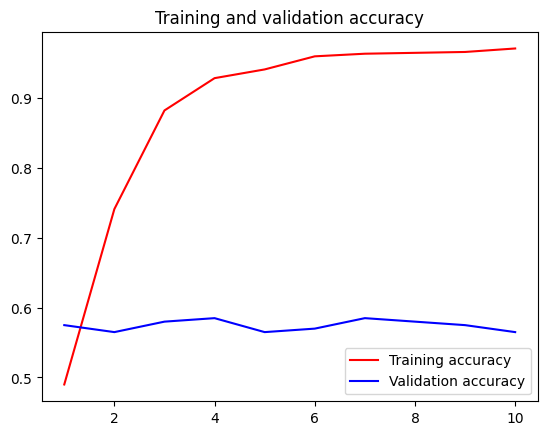

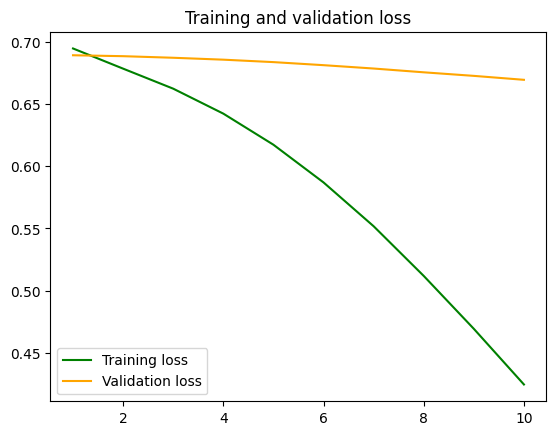

In [43]:
# Extract training history metrics
accuracy = model_4.history['acc']
val_accuracy = model_4.history['val_acc']
loss = model_4.history['loss']
val_loss = model_4.history['val_loss']

# Create a plot for training and validation accuracy
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Display a separate plot for training and validation loss
plt.figure()
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Show the plots
plt.show()


In [44]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)

# Printing the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 1s 1ms/step - loss: 0.6822 - acc: 0.5589
Test loss: 0.6821943521499634
Test accuracy: 0.5589200258255005


#Model 5 - Training a model with an Embedding layer + Conv1D layers+ Dropout using 20000 training samples

In [45]:
# Defining the maximum number of features and maximum sequence length
max_features = 10000
maxlen = 150

# Loading the IMDB dataset with a specified number of words
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Padding the sequences to have a consistent length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Concatenating the training and test sets to create the texts and labels arrays
texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

# Selecting a subset of the training data (20,000 samples)
x_train = x_train[:20000]
y_train = y_train[:20000]


In [47]:
# Creating a Sequential model with embedding and Conv1D layers
model = Sequential()
model.add(Embedding(10000, 10, input_length=maxlen))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# Displaying the model summary
model.summary()

# Training the model and saving the training history
model_5 = model.fit(x_train, y_train,
                      epochs=10,
                      batch_size=32,
                      validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 10)           100000    
                                                                 
 conv1d_3 (Conv1D)           (None, 148, 512)          15872     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 49, 512)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 256)          

#### Extracting and Visualizing Training History

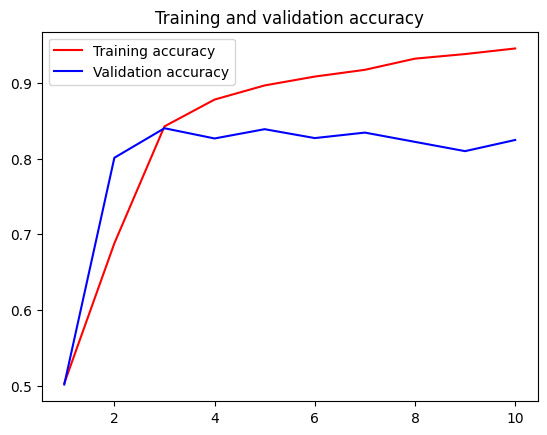

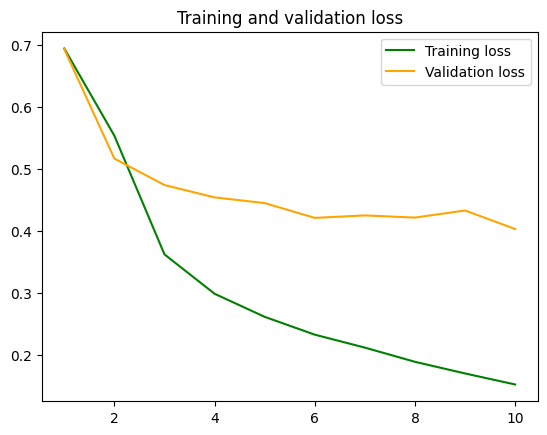

In [48]:
# Extracting training history metrics
accuracy = model_5.history['acc']
val_accuracy = model_5.history['val_acc']
loss = model_5.history['loss']
val_loss = model_5.history['val_loss']

# Creating a range of epochs for plotting
epochs = range(1, len(accuracy) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Creating a new figure for plotting training and validation loss
plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Displaying the plots
plt.show()


In [49]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)

# Printing test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


782/782 [==============================] - 4s 5ms/step - loss: 0.4210 - acc: 0.8131
Test loss: 0.4210130572319031
Test accuracy: 0.8131200075149536


### Conclusion:
#### Improved Accuracy with Conv1D and Larger Training Sample

1. Previous Training Sample Accuracy - Accuracy was still poor.
2. Enhanced Model
    - Employed Conv1D layers.
    - Increased the training sample size.
3. Result
    - Achieved an accuracy of 80%.


# Model 6 with Training sample- 30000 with embedding layers and Conv1D

In [50]:
# Setting up the data with a larger training sample size
max_features = 10000  # Maximum number of words in the vocabulary
maxlen = 150  # Maximum length of input sequences

# Loading the IMDb movie review dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Padding sequences to have a uniform length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Concatenating training and test data for further processing
texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((x_train, x_test), axis=0)

# Selecting a larger training sample size
x_train = x_train[:30000]
y_train = y_train[:30000]


In [51]:
# Creating a sequential model
model = Sequential()

# Adding layers to the model
model.add(Embedding(10000, 12, input_length=maxlen))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# Training the model
model_6 = model.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_split=0.2)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 12)           120000    
                                                                 
 conv1d_6 (Conv1D)           (None, 148, 512)          18944     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 49, 512)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 13, 256)          

#### Extracting and Visualizing Training History

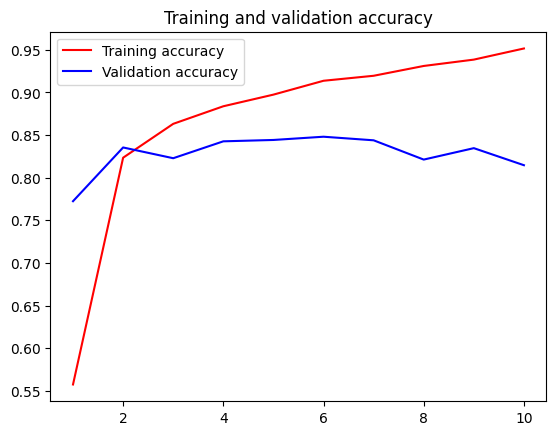

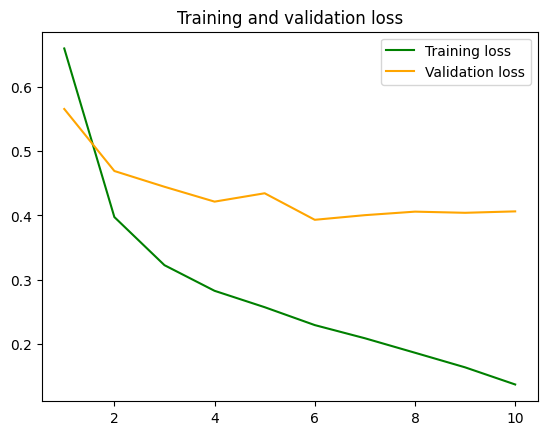

In [52]:
# Extracting training metrics
accuracy = model_6.history['acc']
val_accuracy = model_6.history['val_acc']
loss = model_6.history['loss']
val_loss = model_6.history['val_loss']

# Plotting training and validation accuracy
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Creating a new figure for plotting training and validation loss
plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Displaying the plots
plt.show()


In [53]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


782/782 [==============================] - 4s 5ms/step - loss: 0.4274 - acc: 0.8002
Test loss: 0.4273532032966614
Test accuracy: 0.8002399802207947


# Model 7: Utilizing Pretrained Word Embeddings

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load pre-trained word embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/aclImdb/imdbEr.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Assuming 'texts' is a list of strings
texts = ['your', 'list', 'of', 'strings']

# Set the maximum number of words to use and the embedding dimension
max_words = 10000
embedding_dim = 100

# Tokenize the text and create sequences of integer word indices
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to have a consistent length
if len(sequences) > 0:
    max_sequence_length = max(len(s) for s in sequences)
else:
    max_sequence_length = 0

data = pad_sequences(sequences, maxlen=max_sequence_length)

# Create the embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the RNN model
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'], run_eagerly=True)
model.summary()

# Train the model
tf.config.run_functions_eagerly(True)  # enable eager execution



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1, 100)            500       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,789
Trainable params: 4,289
Non-trainable params: 500
_________________________________________________________________


In [55]:
maxlen = 150
training_samples = 15000
validation_samples = 10000
max_words = 10000

# Initialize a Tokenizer with a specified maximum number of words
tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the texts to generate word indices
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Retrieve the word index from the tokenizer
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pad the sequences to have a consistent length
data = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to a NumPy array
labels = np.asarray(labels)

# Display the shapes of the data and label tensors
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Create indices and shuffle the data and labels accordingly
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split the data into training and validation sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]



Found 4 unique tokens.
Shape of data tensor: (4, 150)
Shape of label tensor: (50000, 150)


In [56]:
# Creating a sequential model
model = Sequential()

# Adding an Embedding layer with a specified input size, embedding dimension, and input length
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Adding an LSTM layer with 32 units
model.add(LSTM(32))

# Adding a Dense layer with 1 unit and a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Displaying the summary of the model architecture
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Create an embedding matrix with zeros
embedding_matrix = np.zeros((max_words, embedding_dim))

# Set the weights of the Embedding layer in the model to the created embedding matrix
model.layers[0].set_weights([embedding_matrix])

# Make the Embedding layer non-trainable
model.layers[0].trainable = False


In [58]:
# Printing the shape of the training label tensor
print("Training data shape:", y_train.shape)


Training data shape: (4, 150)


In [76]:
# Compiling the model with the Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'],
              run_eagerly=True)


# Model 8 - Preparing Data for Training (30000 Samples, Pre-trained Embeddings)

In [60]:
# Define parameters
maxlen = 150
training_samples = 30000
validation_samples = 10000
max_words = 10000

# Tokenize the texts and create sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Get the word index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pad the sequences to have consistent length
data = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to a NumPy array
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Create indices and shuffle the data and labels
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split the data into training and validation sets
x_train = data[:30000]
y_train = labels[:30000]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 4 unique tokens.
Shape of data tensor: (4, 150)
Shape of label tensor: (4, 150)


In [70]:
# Defining the model
model = Sequential()

# Adding an Embedding layer with pretrained word embeddings
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

# Adding an LSTM layer with 128 units
model.add(LSTM(128))

# Adding a Dropout layer with 0.3 dropout rate
model.add(Dropout(0.3))

# Adding a Dense layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Adding a Dropout layer with 0.2 dropout rate
model.add(Dropout(0.2))

# Adding a Dense layer with 1 unit and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Setting the weights for the Embedding layer and make it non-trainable
embedding_matrix = np.resize(embedding_matrix, (10000, 100))
model.layers[0].set_weights([embedding_matrix])

model.layers[0].trainable = False


In [71]:
# Setting Pre-trained Embeddings
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [72]:
# Print the shape of the training data
print("Training data shape:", y_train.shape)

Training data shape: (4, 150)


In [73]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])


In [78]:
model.save_weights('/content/drive/MyDrive/pre_trained_glove_model.8a')

In [80]:
model.load_weights('/content/drive/MyDrive/pre_trained_glove_model.8a')
model.evaluate(x_test, y_test)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


782/782 [==============================] - 194s 248ms/step - loss: 0.6931 - acc: 0.5000


[0.6931474804878235, 0.5]

In [ ]:
pip install nbconvert

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
!jupyter nbconvert --to html /Updated_Sgupta22_Assignment4_TextandSequence.ipynb